In [18]:
# starter imports + mount to drive
import math
import sys
import numpy as np
import re
import random
import os
import cv2

import ipywidgets
from ipywidgets import interact

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend

# from collections import Counter
from matplotlib import pyplot as plt
from PIL import Image

# For confusion matrix
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix

# Google drive access
# from google.colab import drive
# drive.mount('/content/drive')

In [19]:
def files_in_folder(folder_path):
    
    return os.listdir(folder_path)
    # '''
    # Returns a list of strings where each entry is a file in the folder_path, but Jamen fixed it??

    # folder_path : str
    #     A string to folder for which the file listing is returned.
    # '''
    
    # files_A = !ls "{folder_path}"

    # files_list = []
    # for twoFileStr in files_A:
    #     for fileName in twoFileStr.split("\t"):
    #         if len(fileName) > 0: files_list.append(fileName)

    # return files_list


In [20]:
# Load images
dataPath = "data"

galaxyPath = dataPath + "/galaxy"
starPath = dataPath + "/star"

# def files_in_folder(folder_path):
#   '''
#   Returns a list of strings where each entry is a file in the folder_path.

#   folder_path : str
#      A string to folder for which the file listing is returned.
#   '''
#   files_A = !ls "{folder_path}"
#   print(files_A)
#   # The files when listed from Google Drive have a particular format. They are
#   # grouped in sets of 4 and have spaces and tabs as delimiters.

#   # Split the string listing sets of 4 files by tab and space and remove any
#   # empty splits.
#   files_B = [list(filter(None, re.split('\t|\s', files))) for files in files_A]

#   # Concatenate all splits into a single sorted list
#   files_C = []
#   for element in files_B:
#     files_C = files_C + element
#   files_C.sort()

#   return files_C

galaxyImageFileNames = files_in_folder(galaxyPath)
starImageFileNames = files_in_folder(starPath)

## Set Aside Test Data
Pick what images are set aside for testing at the end. I feel like 50 galaxy images and 200 Star images is good. This should be enough for a good sample, but we're limited in the number of galaxy images available

If this section is commented out, it means its already done.

In [21]:
# Make the folders if needed
if not os.path.exists("data/test_star"):
    os.mkdir("data/test_star")

if not os.path.exists("data/test_galaxy"):
    os.mkdir("data/test_galaxy")

test_galaxy_filenames = random.sample(galaxyImageFileNames, 100)
test_star_filenames = random.sample(starImageFileNames, 200)

for fileName in test_galaxy_filenames:
    os.rename("{}/galaxy/{}".format(dataPath, fileName), "{}/test_galaxy/{}".format(dataPath, fileName))
    # test_galaxy_filenames.remove(fileName)

for fileName in test_star_filenames:
    os.rename("{}/star/{}".format(dataPath, fileName), "{}/test_star/{}".format(dataPath, fileName))
    # test_star_filenames.remove(fileName)

Seems to be some issue with appending arrays of arrays where the elements have different shapes. Testing...

In [5]:
# Test np.array having different dimenstion arrays at each index:
# testArr = np.array([[0, 1, 1], 1], dtype=object)
# testArr = np.append(testArr, [[1, 2, 3], 2])
# print(testArr[2])

The arrays didn't seem to work well. I'll use lists, and then I can also just randomize the order with random.shuffle(list)
https://www.w3schools.com/python/ref_random_shuffle.asp

In [6]:
# trainImages = []
# trainImages.append([[1, 2, 3], 4])
# trainImages.append([[4, 2, 3], 5])
# print(trainImages[1][0])

In [7]:
# Now want all the images shuffled together, with all the correct answers in the same order.

# allImages = np.array([[np.array(Image.open(f'{galaxyPath}/{file}')), 0] for file in galaxyImageFileNames[:]])
# print("Done Galaxies")
# allImages = np.append(allImages, np.array([[np.array(Image.open(f'{starPath}/{file}')), 1] for file in starImageFileNames[:]]))

# numImages = allImages.shape[0]
# print("Loaded {:} images from data folders.".format(allImages.shape[0]))


# The individual images are on the level of array[][]

# Display the images in their original state so we can see them
# Figure size in "inches", i guess it determines how it displays on my screen

# fig = plt.figure(figsize=(7, 1.4*numImages))
# for i in range(numImages):
#     fig.add_subplot(numImages/2 + 1, 2, i + 1)
#     plt.imshow(imgset0[i][0])
#     plt.axis('off')
#     plt.title("Figure " + str(i + 1))
# plt.show()

Note: code block below works, but takes ~20 mins on first run. Especially the stars for

*   List item
*   List item

some reason.

In [22]:
# Get the new lists of filenames, excluding ones removed for testing
galaxyImageFileNames = files_in_folder(galaxyPath)
starImageFileNames = files_in_folder(starPath)

trainImages = []
numTotalImages = len(galaxyImageFileNames) + len(starImageFileNames)
imagesLoaded = 0

for file in galaxyImageFileNames:
    trainImages.append([np.array(Image.open(f'{galaxyPath}/{file}'))[:, :, 0], np.array([0, 1])])
    # Note ^ only need 0'th color channel since all channels are the same
    imagesLoaded += 1
    if imagesLoaded % 200 == 0:
        print("Loaded {} of {} images; {}% complete.".format(imagesLoaded,
                                                             numTotalImages, round(100*imagesLoaded/numTotalImages, 1)))

print("Done loading galaxies.")
for file in starImageFileNames:
    trainImages.append([np.array(Image.open(f'{starPath}/{file}'))[:, :, 0], np.array([1, 0])])
    imagesLoaded += 1
    if (imagesLoaded % 200 == 0):
        print("Loaded {} of {} images; {}% complete.".format(imagesLoaded,
                                                             numTotalImages, round(100*imagesLoaded/numTotalImages, 1)))
print("Done loading stars.")

Loaded 200 of 3686 images; 5.4% complete.
Loaded 400 of 3686 images; 10.9% complete.
Loaded 600 of 3686 images; 16.3% complete.
Loaded 800 of 3686 images; 21.7% complete.
Done loading galaxies.
Loaded 1000 of 3686 images; 27.1% complete.
Loaded 1200 of 3686 images; 32.6% complete.
Loaded 1400 of 3686 images; 38.0% complete.
Loaded 1600 of 3686 images; 43.4% complete.
Loaded 1800 of 3686 images; 48.8% complete.
Loaded 2000 of 3686 images; 54.3% complete.
Loaded 2200 of 3686 images; 59.7% complete.
Loaded 2400 of 3686 images; 65.1% complete.
Loaded 2600 of 3686 images; 70.5% complete.
Loaded 2800 of 3686 images; 76.0% complete.
Loaded 3000 of 3686 images; 81.4% complete.
Loaded 3200 of 3686 images; 86.8% complete.
Loaded 3400 of 3686 images; 92.2% complete.
Loaded 3600 of 3686 images; 97.7% complete.
Done loading stars.


Check shape of data and stuff

* Image types are numpy ndarray
* Image sizes are 12288 (changed)
* Image dimensions are (64, 64, 3) (but now changed to (64, 64, 1)
* even though 3 color channels, they all have the same value. Only need one layer.

Shuffle the list, and separate into X and Y datasets (training data and answers)

Stacking arrays: https://stackoverflow.com/questions/56486275/combining-list-of-2d-numpy-arrays


In [23]:
random.shuffle(trainImages)

onlyImages = np.stack([entry[0] for entry in trainImages])
answers = np.stack([entry[1] for entry in trainImages])

In [24]:
conv_model = models.Sequential()
# 32, 3, 3 makes a 3 by 3 filter thing for 32 things
# input shape is the dimensions of the images. (Change RGB -> Greyscale to speed up?)
conv_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dropout(0.5))
conv_model.add(layers.Dense(256, activation='relu'))
# 2 is because there are 2 outputs (galaxy or star)
conv_model.add(layers.Dense(2, activation='softmax'))

LEARNING_RATE = 1e-4
conv_model.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.RMSprop(learning_rate=LEARNING_RATE), metrics=['acc'])

In [26]:
VALIDATION_SPLIT = 0.1 #how much of the data to use for training vs testing

# optional to reset the thingies
# X_dataset is inputs, Y_dataset is desired outputs
history_conv = conv_model.fit(onlyImages, answers, validation_split=VALIDATION_SPLIT, epochs=20, batch_size=32)
# ^ originally was 20 epochs, batch size 16
# ^ batch size was originally 16; changed to 8


Epoch 1/20
104/104 [==============================] - 13s 121ms/step - loss: 0.4800 - acc: 0.7772 - val_loss: 0.5138 - val_acc: 0.7615
Epoch 2/20
104/104 [==============================] - 14s 133ms/step - loss: 0.4141 - acc: 0.8107 - val_loss: 0.3972 - val_acc: 0.8320
Epoch 3/20
104/104 [==============================] - 14s 132ms/step - loss: 0.3691 - acc: 0.8411 - val_loss: 0.8582 - val_acc: 0.5339
Epoch 4/20
104/104 [==============================] - 15s 145ms/step - loss: 0.3261 - acc: 0.8619 - val_loss: 0.3230 - val_acc: 0.8618
Epoch 5/20
104/104 [==============================] - 15s 146ms/step - loss: 0.2913 - acc: 0.8797 - val_loss: 0.2765 - val_acc: 0.8753
Epoch 6/20
104/104 [==============================] - 16s 152ms/step - loss: 0.2745 - acc: 0.8866 - val_loss: 0.7479 - val_acc: 0.6233
Epoch 7/20
104/104 [==============================] - 17s 162ms/step - loss: 0.2459 - acc: 0.9002 - val_loss: 1.1223 - val_acc: 0.5203
Epoch 8/20
104/104 [==============================] - 1

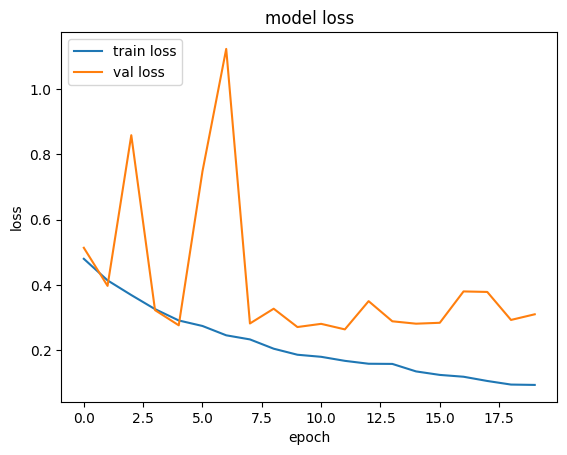

In [27]:
# Plot top losses
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')

# interesting to see on a log plot too
#ax = plt.gca()
#ax.set_yscale('log')
plt.show()

Use the model to predict the test images. Start by loading the test images.

predictionsIndexes is a 1d array containing index of max entry on that row.

In [28]:
#load the test images
galaxyPath = dataPath + "/test_galaxy"
starPath = dataPath + "/test_star"

galaxyImageFileNames = files_in_folder(galaxyPath)
starImageFileNames = files_in_folder(starPath)

testImages = []
numTotalImages = len(galaxyImageFileNames) + len(starImageFileNames)
imagesLoaded = 0

for file in galaxyImageFileNames:
    testImages.append([np.array(Image.open(f'{galaxyPath}/{file}'))[:, :, 0], np.array([0, 1])])
    # Note ^ only need 0'th color channel since all channels are the same
    imagesLoaded += 1
    if imagesLoaded % 50 == 0:
        print("Loaded {} of {} images; {}% complete.".format(imagesLoaded,
                                                             numTotalImages, round(100*imagesLoaded/numTotalImages, 1)))

print("Done loading test galaxies.")
for file in starImageFileNames:
    testImages.append([np.array(Image.open(f'{starPath}/{file}'))[:, :, 0], np.array([1, 0])])
    imagesLoaded += 1
    if (imagesLoaded % 50 == 0):
        print("Loaded {} of {} images; {}% complete.".format(imagesLoaded,
                                                             numTotalImages, round(100*imagesLoaded/numTotalImages, 1)))
print("Done loading test stars.")

# Shuffle and separate into data and answers
random.shuffle(testImages)
onlyTestImages = np.stack([entry[0] for entry in testImages])
testAnswers = np.stack([entry[1] for entry in testImages])

print(testAnswers.shape)
print(onlyTestImages.shape)

Loaded 50 of 300 images; 16.7% complete.
Loaded 100 of 300 images; 33.3% complete.
Done loading test galaxies.
Loaded 150 of 300 images; 50.0% complete.
Loaded 200 of 300 images; 66.7% complete.
Loaded 250 of 300 images; 83.3% complete.
Loaded 300 of 300 images; 100.0% complete.
Done loading test stars.
(300, 2)
(300, 64, 64)


10/10 [==============================] - 0s 28ms/step
What is the average confidence in the correct answer, based on the ground truth of the image?
Star:   95.1%
Galaxy: 44.4%
[[186  14]
 [ 35  65]]


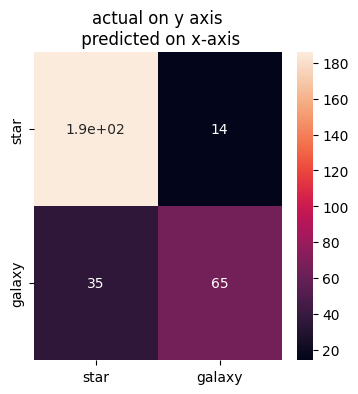

In [37]:
predictions_raw = conv_model.predict(onlyTestImages, use_multiprocessing=True)
predictions_old = np.argmax(predictions_raw, axis=1)
Y_dataset_1D = np.argmax(testAnswers, axis=1)

# Make predictions; if high confidence of star, pick star, otherwise pick galaxy
predictions = []
THRESH = 0.85

for index in range(len(predictions_old)):
    if predictions_raw[index][0] > THRESH:
        predictions.append(0)
    else:
        predictions.append(1)

predictions = np.array(predictions)

galaxyNumber = 0
starNumber = 0
totalGalaxyConfidence = 0
totalStarConfidence = 0

for index in range(len(predictions_old)):
    if Y_dataset_1D[index] == 1: # Since index 1 is where you find the value of 1 in the answer vector representing galaxy
        star_or_galaxy = "galaxy."
        galaxyNumber += 1
        totalGalaxyConfidence += predictions_raw[index][1]
    else:
        star_or_galaxy = "star.  "
        starNumber += 1
        totalStarConfidence += predictions_raw[index][0]

    # print("Object: {} confidence: {}".format(star_or_galaxy, max(predictions_raw[index])))


print("What is the average confidence in the correct answer, based on the ground truth of the image?")
print("Star:   {}%".format(round(100*totalStarConfidence/starNumber, 1)))
print("Galaxy: {}%".format(round(100*totalGalaxyConfidence/galaxyNumber, 1)))

# print(predictions_raw)
# print(predictions.shape)
# print(Y_dataset_1D.shape)

# Plot Confusion matrix
conf_mat = confusion_matrix(Y_dataset_1D, predictions)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ["star", "galaxy"]],
                  columns = [i for i in ["star", "galaxy"]])
plt.figure(figsize = (4, 4))
plt.title("actual on y axis\n predicted on x-axis")
plt.xlabel("predicted")
plt.ylabel("actual")
sn.heatmap(df_cm, annot=True)

print(conf_mat)

## Save the model
All of these should work, just different file types 

In [38]:
# conv_model.save("kaggle_astro_model.h5") # .h5 is the old file type
conv_model.save('kaggle_astro_model.keras')

c:\Users\jamen\OneDrive\UBC 5th year\ENPH 479\code\env-stellar\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
